1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
    - бустинг
    - логистическая регрессия
2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)
4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. *Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

--2022-03-24 13:53:16--  https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91
Resolving drive.google.com (drive.google.com)... 172.217.0.46, 2607:f8b0:4004:82f::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v8giakd7l6v47qsu1so2bfbfrn88uo25/1648129950000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download [following]
--2022-03-24 13:53:17--  https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v8giakd7l6v47qsu1so2bfbfrn88uo25/1648129950000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download
Resolving doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercontent.com)... 142.251.45.1, 2607:f8b0:4004:83e::2001
Connecting to doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercont

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
final_transformers = []

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [7]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [8]:
models_results = {'approach': [], 'F-Score': [], 'Precision': [], 'Recall': [], 'Threshold': []}

In [9]:
Rand_forest = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=1, random_state=42,
                                          class_weight={0:1, 1:4})),
])
Rand_forest.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [10]:
preds_forest = Rand_forest.predict_proba(X_test)[:, 1]

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_forest)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
models_results['approach'].append('RandomForestClassifier')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Threshold'].append(thresholds[ix])

print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.42, F-Score=0.644, Precision=0.704, Recall=0.593


In [12]:
pd.DataFrame(data=models_results)

,approach,F-Score,Precision,Recall,Threshold
0,RandomForestClassifier,0.643923,0.703963,0.59332,0.42


In [13]:
lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=23)),
])
lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
preds_lr = lr.predict_proba(X_test)[:, 1]

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
models_results['approach'].append('LogisticRegression')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Threshold'].append(thresholds[ix])

print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.28952195521654284, F-Score=0.510, Precision=0.462, Recall=0.568


In [16]:
pd.DataFrame(data=models_results)

,approach,F-Score,Precision,Recall,Threshold
0,RandomForestClassifier,0.643923,0.703963,0.59332,0.420000
1,LogisticRegression,0.509700,0.462400,0.56778,0.289522


In [17]:
gb = Pipeline([('features', feats),
               ('classifier', GradientBoostingClassifier(random_state=23))])
gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [18]:
from sklearn.model_selection import GridSearchCV
params_gb = {
    'classifier__learning_rate':[0.05, 0.08, 0.1],
    'classifier__n_estimators':[100, 150, 200, 250, 300],
    'classifier__max_depth':[1, 2, 3, 4, 5, 6],
    'classifier__min_samples_leaf':[1, 2, 3, 4, 5]
}

In [19]:
preds_gb = gb.predict_proba(X_test)[:, 1]

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
models_results['approach'].append('GradientBoostingClassifier')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Threshold'].append(thresholds[ix])

print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4085078904556646, F-Score=0.646, Precision=0.704, Recall=0.597


In [21]:
pd.DataFrame(data=models_results)

,approach,F-Score,Precision,Recall,Threshold
0,RandomForestClassifier,0.643923,0.703963,0.59332,0.420000
1,LogisticRegression,0.509700,0.462400,0.56778,0.289522
2,GradientBoostingClassifier,0.646121,0.703704,0.59725,0.408508


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


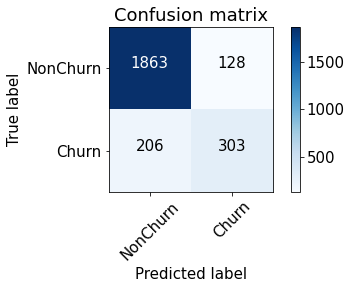

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb > models_results['Threshold'][2])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [24]:
def buisness_profit(cnf_matrix):

  TN = cnf_matrix[0][0]
  FP = cnf_matrix[0][1]
  FN = cnf_matrix[1][0]
  TP = cnf_matrix[1][1]


  retain_sum = (FP + TP) * 1
  income = TP * 2

  return income - retain_sum

In [25]:
gb_profit = buisness_profit(cnf_matrix_gb)
gb_profit

175

По метрикам лучше всего работает градиентный бустинг. Но экономически выгодно будет использовать лес с параметрами. 